### Importing Libraries and Reading the File

In [25]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import backtesting
backtesting.set_bokeh_output(notebook=True)
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import ta.trend as tr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_excel("D:DataSets/BankNiftyFutures_Data5Min.xlsx")

In [3]:
data.head()

,Ticker,Date,Final Date format,Time,Open 5,High 5,Low 5,Close 5,Volume 5,Year
0,BANKNIFTY_F1,2015-01-01,20150101,09:20:00,18861.3496,18867.9492,18793.0000,18808.3496,84825,2015
1,BANKNIFTY_F1,2015-01-01,20150101,09:25:00,18808.0000,18835.0000,18802.1992,18829.0000,40925,2015
2,BANKNIFTY_F1,2015-01-01,20150101,09:30:00,18826.9492,18833.4004,18820.0000,18826.0996,27000,2015
3,BANKNIFTY_F1,2015-01-01,20150101,09:35:00,18825.0508,18829.0996,18810.0000,18810.0000,18025,2015
4,BANKNIFTY_F1,2015-01-01,20150101,09:40:00,18805.0000,18808.9492,18775.0000,18803.9492,60100,2015


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91737 entries, 0 to 91736
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ticker             91737 non-null  object        
 1   Date               91737 non-null  datetime64[ns]
 2   Final Date format  91737 non-null  int64         
 3   Time               91737 non-null  object        
 4   Open 5             91737 non-null  float64       
 5   High 5             91737 non-null  float64       
 6   Low 5              91737 non-null  float64       
 7   Close 5            91737 non-null  float64       
 8   Volume 5           91737 non-null  int64         
 9   Year               91737 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 7.0+ MB


In [5]:
data.nunique()

Ticker                   1
Date                  1226
Final Date format     1226
Time                   450
Open 5               63890
High 5               59286
Low 5                61098
Close 5              63852
Volume 5             14248
Year                     5
dtype: int64

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### Task 2 Backtest Using Python

In [6]:
#Formation of reuired dataframe for backtest
#Group By is by using the mean of 15 min time frame values 

df=data.groupby('Date')['Open 5','High 5','Low 5','Volume 5','Close 5'].mean()
df.columns=['Open','High','Low','Volume','Close']
df['Volume']=df['Volume'].astype(int)
df.reset_index(inplace=True)
df.set_index('Date',inplace=True)

In [7]:
#Using Backtest Library and Pre-Provided Code,

class strategy(Strategy):
    def init(self):
        cp = pd.Series(self.data.Close)
        
        self.ema1 = self.I(tr.ema_indicator,close=cp, window=20);
        self.ema2 = self.I(tr.sma_indicator,close=cp, window=200)
        

    def next(self):
        # Buy or sell on ema -> sma cross over
        # Have a 200 pts stop loss for long trades and 130 points for short trades
        if crossover(self.ema1, self.ema2):
            self.buy(sl=self.data.High-200)
        elif crossover(self.ema2, self.ema1):
            self.sell(sl=self.data.Low+130)
            
bt = Backtest(df, strategy, commission=.002,cash=1000000,
              exclusive_orders=True)
# Run the backtest
stats = bt.run()
 
# Print the performance metrics for this strategy 
print(stats)

# Plot the price movements, trades and other meta-data such as drawdown etc.
bt.plot(resample=True);

Start                     2015-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                     49.6737
Equity Final [$]                  1.32333e+06
Equity Peak [$]                   1.55109e+06
Return [%]                            32.3325
Buy & Hold Return [%]                 71.7931
Return (Ann.) [%]                     5.92736
Volatility (Ann.) [%]                 10.2579
Sharpe Ratio                         0.577832
Sortino Ratio                        0.908453
Calmar Ratio                          0.29168
Max. Drawdown [%]                    -20.3215
Avg. Drawdown [%]                    -2.75278
Max. Drawdown Duration      701 days 00:00:00
Avg. Drawdown Duration       57 days 00:00:00
# Trades                                    9
Win Rate [%]                          33.3333
Best Trade [%]                        28.1881
Worst Trade [%]                      -4.36644
Avg. Trade [%]                    

In [8]:
#DataFrame of Trades

stats._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,60,341,495,16558.924508,18013.938779,87300.856228,0.087869,2016-05-23,2017-01-04,226 days
1,-60,495,497,17977.910901,18306.550704,-19718.388173,-0.018280,2017-01-04,2017-01-06,2 days
2,56,502,795,18937.508795,24275.625419,298934.530939,0.281881,2017-01-13,2018-03-22,433 days
3,-56,795,803,24227.074168,24552.173227,-18205.547295,-0.013419,2018-03-22,2018-04-05,14 days
4,52,822,919,25675.257475,25225.853387,-23369.012589,-0.017503,2018-05-03,2018-09-24,144 days
5,-53,927,930,24806.763091,25065.848779,-13731.541469,-0.010444,2018-10-05,2018-10-10,5 days
6,48,964,966,27006.479132,26662.397276,-16515.929102,-0.012741,2018-12-03,2018-12-05,2 days
7,-48,1141,1143,26920.228989,28095.685419,-56421.908609,-0.043664,2019-08-23,2019-08-27,4 days
8,40,1184,1225,30281.916985,32408.223307,85052.252850,0.070217,2019-10-31,2019-12-31,61 days


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### Task 3 Converting into 15 min Time Frames

In [9]:
data.head()

,Ticker,Date,Final Date format,Time,Open 5,High 5,Low 5,Close 5,Volume 5,Year
0,BANKNIFTY_F1,2015-01-01,20150101,09:20:00,18861.3496,18867.9492,18793.0000,18808.3496,84825,2015
1,BANKNIFTY_F1,2015-01-01,20150101,09:25:00,18808.0000,18835.0000,18802.1992,18829.0000,40925,2015
2,BANKNIFTY_F1,2015-01-01,20150101,09:30:00,18826.9492,18833.4004,18820.0000,18826.0996,27000,2015
3,BANKNIFTY_F1,2015-01-01,20150101,09:35:00,18825.0508,18829.0996,18810.0000,18810.0000,18025,2015
4,BANKNIFTY_F1,2015-01-01,20150101,09:40:00,18805.0000,18808.9492,18775.0000,18803.9492,60100,2015


In [10]:
#Since the tickare has 0 variance and final date format is same as date, we will remove them

data.drop(['Ticker','Final Date format'],axis=1,inplace=True)

In [11]:
#Code for 15 min time frame

j=0
now=pd.DataFrame()
for k in data['Date'].unique():
    new=data[data['Date']==k]
    new.reset_index(inplace=True,drop=True)
    new['Open']=" "
    new['Close']=" "
    new['Low']=" "
    new['Volume']=" "
    new['High']=" "
    
    for i in range(new.index[0],len(new),3):
        #Since 5 min time frame is given so, step size of 3 will make it 15 min time frame
        j=i+2
        new['High'][j+1]=new['High 5'][i:j+1].mean()
        new['Open'][j+1]=new['Open 5'][i:j+1].mean()
        new['Low'][j+1]=new['Low 5'][i:j+1].mean()
        new['Close'][j+1]=new['Close 5'][i:j+1].mean()
        new['Volume'][j+1]=new['Volume 5'][i:j+1].mean()
        
        #Storing the 15 min time frames value to the every fourth index of data
        
    now=pd.concat([new[new['Open']!=" "],now])
    
final_data=now.drop(['High 5','Open 5','Low 5','Close 5','Volume 5'], axis=1)

In [12]:
final_data.head()

,Date,Time,Year,Open,Close,Low,Volume,High
3,2019-12-31,09:31:00,2019,32461.7,32410,32398.6,78020,32473.7
6,2019-12-31,09:46:00,2019,32397.4,32391.8,32379.1,46920,32410.2
9,2019-12-31,10:01:00,2019,32372.5,32368.1,32355.3,38413.3,32383.3
12,2019-12-31,10:16:00,2019,32375.1,32379.4,32369.1,25973.3,32391.6
15,2019-12-31,10:31:00,2019,32378.6,32373.9,32362.2,14673.3,32384.3


### Task 4-8 and After, Intraday Calculations

In [13]:
#Converting all values to float for easy 

for i in ['Open','Close','Low','Volume','High']:
    final_data[i]=final_data[i].astype(float)

In [14]:
final_data.dtypes

Date      datetime64[ns]
Time              object
Year               int64
Open             float64
Close            float64
Low              float64
Volume           float64
High             float64
dtype: object

#### Calculation of VWAP 

In [15]:
def calculateVwap(data):

        data['TP'] = (data['High']+data['Low']+data['Close'])/3.0
        data['TradedValue']  = data['TP']*data['Volume']
        data['CumVolume'] = data['Volume'].cumsum()
        data['CumTradedValue'] = data['TradedValue'].cumsum()
        data['VWAP'] = data['CumTradedValue'] / (data['CumVolume'])
        return data
        
data_vwap= final_data.groupby('Date').apply(calculateVwap)

In [16]:
data_vwap.head()

,Date,Time,Year,Open,Close,Low,Volume,High,TP,TradedValue,CumVolume,CumTradedValue,VWAP
3,2015-01-01,09:35:00,2015,18832.099600,18821.149733,18805.066400,50916.666667,18845.449867,18823.888667,9.584497e+08,50916.666667,9.584497e+08,18823.888667
3,2015-01-02,09:31:00,2015,18931.966800,18965.199867,18926.566400,73608.333333,18980.016933,18957.261067,1.395412e+09,73608.333333,1.395412e+09,18957.261067
3,2015-01-05,09:32:00,2015,19205.333333,19186.333333,19161.850267,126600.000000,19239.799467,19195.994356,2.430213e+09,126600.000000,2.430213e+09,19195.994356
3,2015-01-06,09:33:00,2015,18997.266933,18922.866533,18903.450533,180825.000000,19020.216800,18948.844622,3.426425e+09,180825.000000,3.426425e+09,18948.844622
3,2015-01-07,09:34:00,2015,18500.649733,18493.500000,18446.333333,143591.666667,18578.633467,18506.155600,2.657330e+09,143591.666667,2.657330e+09,18506.155600


#### If candle closes above VWAP, we will buy and if candle closes below VWAP, we will sell

#### Assumptions:-
1. Buy column is used to mention where close is above VWAP, buy will take place.
2. Buy Prie is the High Price at which buy occurs
3. Stop loss of buy is at the low price

In [17]:
data_vwap['Buy']=" "
data_vwap['Buy Price']=" "
data_vwap['Stop Loss']=" "
data_vwap.reset_index(inplace=True,drop=True)

In [18]:
for i in range(0,len(data_vwap)):
    if data_vwap['Close'][i]>data_vwap['VWAP'][i]:
        data_vwap['Buy'][i]='Buy'
        data_vwap['Buy Price'][i]=data_vwap['High'][i]
        data_vwap['Stop Loss'][i]=data_vwap['Low'][i]   

#### If stop loss is not hit, then all trades are exited at 3:15 PM and trade starts only after 2nd 15-minute candle (9:30 to 9:45)

#### Assumptions:-
1. Sell column is used define where sell occurs of all the buys.
2. The sell will occur of total buys before that sell options on that day.
3. Example, if 4 buys occurs in a day consequetively, then next sell will occur of 4 units that were purchased before on that day
4. Sell is at the low price of that moment.
5. Amount is the cost at which sell or buy occurs.
6. Units are total units by or sell occurs.
7. 1 unit of buy takes place only everytime.
8. Amount of sell = Number of units * Low Price
9. Since, ending of day is not exact st 3:15 PM but at 3:16 to 3:20 PM. Hence these timings are used for convenience.

In [19]:
count=0
df_Amount=pd.DataFrame()

for k in data_vwap.Date.unique():
    #providing the dataframe filtered with dates
    
    d=data_vwap[data_vwap['Date']==k]
    d.reset_index(inplace=True,drop=True)
    d['Sell']=" "
    d['Amount (Rs)']=" "
    d['Units']=" "

    for i in d.index:
        
        if d['Buy'][i]=='Buy':
            d['Amount (Rs)'][i]=-d['High'][i]
            d['Units'][i]=1
            count=count+1
            try:
                if d['Buy'][i+1]==' ':
                    d['Sell'][i+1]='Sell'
                    d['Amount (Rs)'][i+1]=float(d['Low'][i+1])*count
                    d['Units'][i+1]=count          
                    count=0
            except:
                d['Sell'][i]="Sell"
                d['Amount (Rs)'][i]=float(d['Low'][i])*count
                #As per above Instructions
                d['Units'][i]=count 
                
    df_Amount=pd.concat([d,df_Amount])
df_Amount.reset_index(inplace=True,drop=True)   

### Task 9 Calculation of Overall Profit/Loss

In [21]:
print("The overall profit or loss is Rs", "{:.4f}".format(df_Amount['Amount (Rs)'].replace(" ",0).sum()))

The overall profit or loss is Rs 210985339.5157


### Task 10 Calculation of Profit/Loss Year Wise

In [22]:
year_list=[]
amount_list=[]
for i in df_Amount['Year'].unique():
        print(" The profit for year {0} is Rs {1}".format(i, "{:.4f}".format(df_Amount[df_Amount['Year']==i]['Amount (Rs)'].replace(" ",0).sum())))
        amount_list.append(df_Amount[df_Amount['Year']==i]['Amount (Rs)'].replace(" ",0).sum())
        year_list.append(i)

 The profit for year 2019 is Rs 54378707.9860
 The profit for year 2018 is Rs 47691359.6821
 The profit for year 2017 is Rs 47529940.5416
 The profit for year 2016 is Rs 34634987.0409
 The profit for year 2015 is Rs 26750344.2650


Text(0, 0.5, 'Profit Earned')

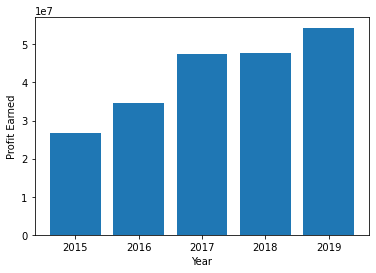

In [28]:
plt.bar(year_list,amount_list)
plt.xlabel("Year")
plt.ylabel('Profit Earned')

### Task 10 Calculation of Profit/Loss Day Wise

In [29]:
df_Amount['Profit/Loss (Rs)']=" "
for i in df_Amount['Date'].unique():
    df_Amount['Profit/Loss (Rs)'][df_Amount[df_Amount['Date']==i].index[-1]]=df_Amount[df_Amount['Date']==i]['Amount (Rs)'].replace(" ",0).sum()

In [30]:
Pro_Loss_DateWise=df_Amount[df_Amount['Profit/Loss (Rs)']!=" "].reset_index(drop=True)

In [31]:
print("The Date wise profit/loss dataframe head is ")
pd.set_option("display.max_columns",35)
Pro_Loss_DateWise.head()

The Date wise profit/loss dataframe head is 


,Date,Time,Year,Open,Close,Low,Volume,High,TP,TradedValue,CumVolume,CumTradedValue,VWAP,Buy,Buy Price,Stop Loss,Sell,Amount (Rs),Units,Profit/Loss (Rs)
0,2019-12-31,15:16:00,2019,32389.733067,32389.666667,32380.483733,31740.000000,32399.366533,32389.838978,1.028053e+09,687373.333333,2.227799e+10,32410.327496,,,,Sell,453327,14,-903.144
1,2019-12-30,15:16:00,2019,32554.216800,32550.716800,32533.816400,33900.000000,32574.833333,32553.122178,1.103551e+09,815946.666667,2.659189e+10,32590.236045,,,,,,,784291
2,2019-12-27,15:16:00,2019,32569.566400,32589.583333,32559.666667,46760.000000,32601.099600,32583.449867,1.523602e+09,760513.333333,2.468450e+10,32457.684219,Buy,32601.1,32559.7,Sell,781432,24,33746.8
3,2019-12-26,15:16:00,2019,32007.800133,31998.199867,31985.617200,51453.333333,32019.500000,32001.105689,1.646564e+09,719200.000000,2.311712e+10,32142.827919,,,,,,,-25.8997
4,2019-12-24,15:16:00,2019,32309.850267,32310.500000,32297.283867,33900.000000,32329.466800,32312.416889,1.095391e+09,477033.333333,1.542554e+10,32336.408773,,,,,,,-295.686


### Task 11 Best Performing Year

In [32]:
print("The best performing year is with maximum profit or minimum loss", year_list[np.argmax(amount_list)] , "with amount",max(amount_list) )

The best performing year is with maximum profit or minimum loss 2019 with amount 54378707.986
